In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab/leftover

/content/drive/MyDrive/Colab/leftover


In [3]:
%run prepare_images.py datasets/horizontal_photos

Copied images from datasets/horizontal_photos/1
Copied images from datasets/horizontal_photos/0


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import shutil
import math
from IPython.display import Image as IPImage
from IPython.display import display_jpeg
import visualize

print(tf.__version__)

train_dir = 'target_datasets/train'
val_dir = 'target_datasets/val'

backup_dir = './model'

labels = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
labels.sort()
print(labels)

if os.path.exists(backup_dir):
    shutil.rmtree(backup_dir)

os.makedirs(backup_dir)

with open(backup_dir + '/labels.txt','w') as f:
    for label in labels:
        f.write(label+"\n")

NUM_CLASSES = len(labels)
print("class number=" + str(NUM_CLASSES))

labels = []
with open(backup_dir + '/labels.txt','r') as f:
    for line in f:
        labels.append(line.rstrip())
print(labels)

2.11.0
['0', '1']
class number=2
['0', '1']


Found 56 images belonging to 2 classes.
Found 15 images belonging to 2 classes.
## Train Data Sample ##


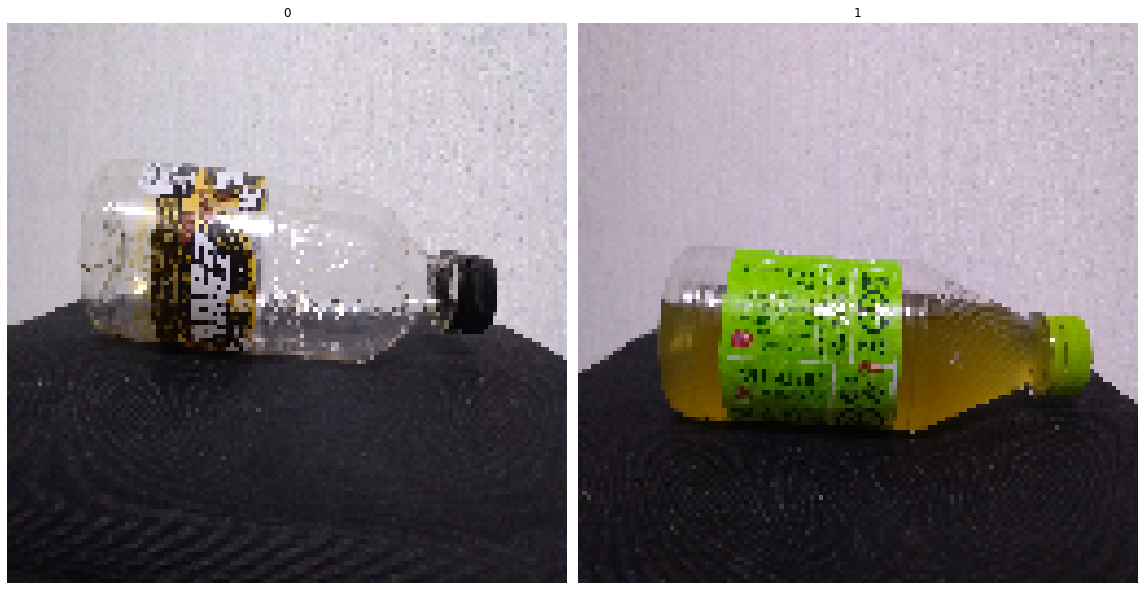

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 36)      1008      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 36)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 36)        0         
                                                                 
 activation (Activation)     (None, 63, 63, 36)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 24)        7800      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 24)       0         
 2D)                                                    

In [5]:
# 学習率
LEARNING_RATE = 0.002
# エポック
EPOCHS = 30
# バッチサイズ
BATCH_SIZE = 8

IMAGE_SIZE = 128

#RGBは1~255をとるので正規化処理として1/255する。
#train_data_gen = ImageDataGenerator(rescale=1./255)
train_data_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
val_data_gen = ImageDataGenerator(rescale=1./255)

# メモ：ImageDataGenerator.flow_from_directory はIteratorを返す
train_data = train_data_gen.flow_from_directory(
    train_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb', batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True)

validation_data = val_data_gen.flow_from_directory(
    val_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb', batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False)

# Display train data sample
visualize.pick_train_sample(labels, train_data)

# AI model definition
model = Sequential()

model.add(Conv2D(36, (3, 3),
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Activation('relu'))

model.add(Conv2D(24, (3, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Activation('relu'))

model.add(Conv2D(18, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))

opt = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
#opt = tf.keras.optimizers.SGD(lr=LEARNING_RATE)

model.compile(opt, loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

# Execute train
history = model.fit(train_data, epochs=EPOCHS, validation_data=validation_data, verbose=1)

score = model.evaluate(validation_data)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2/2 [==============================] - 4s 2s/step
Prediction data
[[0.945 0.055]
 [0.934 0.066]
 [0.962 0.038]
 [0.913 0.087]
 [0.984 0.016]
 [0.001 0.999]
 [0.003 0.997]
 [0.206 0.794]
 [0.008 0.992]
 [0.184 0.816]
 [0.    1.   ]
 [0.033 0.967]
 [0.033 0.967]
 [0.    1.   ]
 [0.    1.   ]]
(15, 2)
#0 Expected:0 -> Predicted:0
File: 0/P_20221006_002304.jpg
Each Prediction Value: [0.945 0.055]
* Correct *
#1 Expected:0 -> Predicted:0
File: 0/P_20221006_002327.jpg
Each Prediction Value: [0.934 0.066]
* Correct *
#2 Expected:0 -> Predicted:0
File: 0/P_20221006_002349.jpg
Each Prediction Value: [0.962 0.038]
* Correct *
#3 Expected:0 -> Predicted:0
File: 0/P_20221009_171948.jpg
Each Prediction Value: [0.913 0.087]
* Correct *
#4 Expected:0 -> Predicted:0
File: 0/P_20221009_171959.jpg
Each Prediction Value: [0.984 0.016]
* Correct *
#5 Expected:1 -> Predicted:1
File: 1/P_20221006_000854.jpg
Each Prediction Value: [0.001 0.999]
* Correct *
#6 Expected:1 -> Predicted:1
File: 1/P_20221006_0009

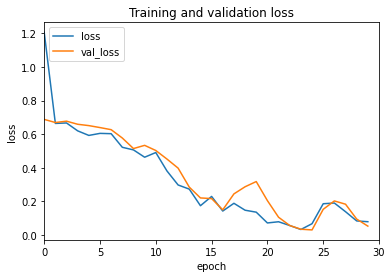

Accuracy


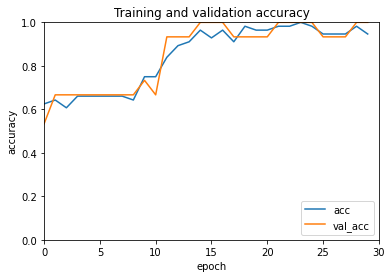

15/15 [==============================] - 6s 429ms/step
Confusion Matrix


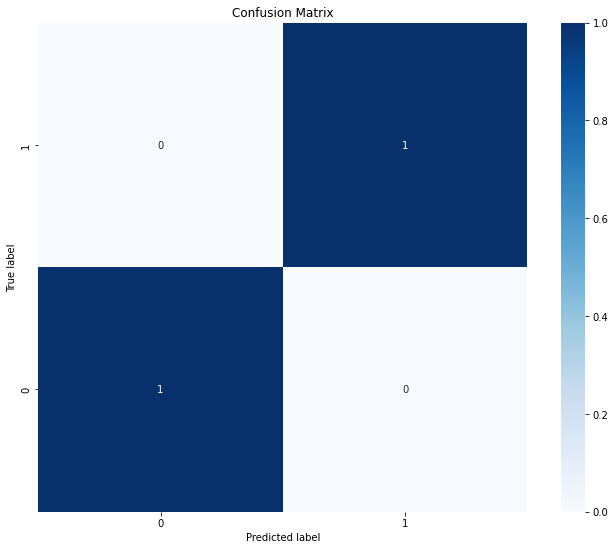

In [6]:
# Failed pictures
visualize.vis_failed_pic(model, labels, validation_data, val_dir, BATCH_SIZE, 100)

# Visualize loss
visualize.vis_loss_accuracy(history, EPOCHS)

# Save model
save_model_path = os.path.join(backup_dir, 'my_model.h5')
model.save(save_model_path)

# Confusion Matrix
visualize.vis_confusion_matrix(model, validation_data)

In [7]:
#visualize.vis_filter(model, 'conv2d_')
#visualize.vis_filter(model, 'conv2d_1')

In [8]:
!cat incorrect.txt

In [9]:
visualize.vis_hidden_layer('incorrect.txt', 'activation_2', IMAGE_SIZE)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 36)      1008      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 36)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 36)        0         
                                                                 
 activation (Activation)     (None, 63, 63, 36)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 24)        7800      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 24)       0         
 2D)                                                    